# 实验3 Logistic回归
    
【高校录取预测】：根据申请学生的两门课程成绩预测是否被录取

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

## 1. 数据准备
### 1.1 读取数据

In [2]:
data = np.loadtxt('./ex3data.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2]
m, n = X.shape
print(X)
print(y)
print(X.shape,X.ndim)

[[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]
 [45.08327748 56.31637178]
 [61.10666454 96.51142588]
 [75.02474557 46.55401354]
 [76.0987867  87.42056972]
 [84.43281996 43.53339331]
 [95.86155507 38.22527806]
 [75.01365839 30.60326323]
 [82.30705337 76.4819633 ]
 [69.36458876 97.71869196]
 [39.53833914 76.03681085]
 [53.97105215 89.20735014]
 [69.07014406 52.74046973]
 [67.94685548 46.67857411]
 [70.66150955 92.92713789]
 [76.97878373 47.57596365]
 [67.37202755 42.83843832]
 [89.67677575 65.79936593]
 [50.53478829 48.85581153]
 [34.21206098 44.2095286 ]
 [77.92409145 68.97235999]
 [62.27101367 69.95445795]
 [80.19018075 44.82162893]
 [93.1143888  38.80067034]
 [61.83020602 50.25610789]
 [38.7858038  64.99568096]
 [61.37928945 72.80788731]
 [85.40451939 57.05198398]
 [52.10797973 63.12762377]
 [52.04540477 69.43286012]
 [40.23689374 71.16774802]
 [54.63510555 52.21388588]
 [33.91550011 98.86943574]
 

### 1.2 绘制散点图

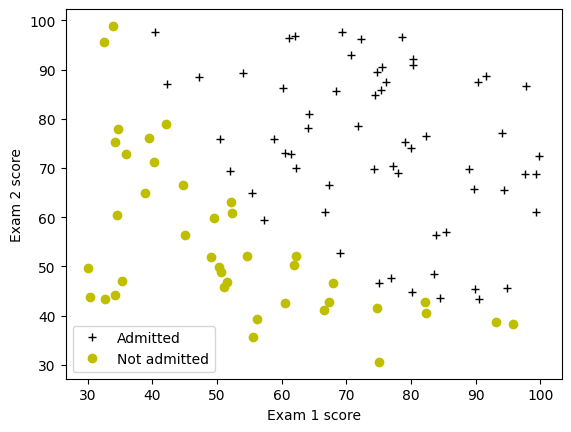

In [3]:
pos = X[data[:,2] == 1, :]
neg = X[data[:,2] == 0, :]
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.plot(pos[:,0], pos[:,1], '+k', label='Admitted') # 绘制正例
plt.plot(neg[:,0], neg[:,1], 'oy', label='Not admitted') # 绘制负例
plt.legend()
plt.show()


### 1.3 数据预处理
1、为输入数据X加全1列（X0）

2、X、y做好转置

In [4]:
x0 = np.ones((m,1))
X = np.hstack((x0,X)).T
#数组拼接方法可使用np.hstack或np.append
y = data[:, [2]].T
print(X.shape,X.ndim)

(3, 100) 2


## 2. 实现基于交叉熵的损失函数

### 2.1 定义Sigmoid函数

In [5]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))            # 使用np.exp()进行自然指数运算
    return g

print(sigmoid(0), sigmoid(-100),sigmoid(10))
tmp = np.array([-5, -2, 0, 1, 3])
print(sigmoid(tmp))


0.5 3.7200759760208356e-44 0.9999546021312976
[0.00669285 0.11920292 0.5        0.73105858 0.95257413]


### 2.2 实现损失函数、梯度

In [6]:
# 因为代价函数和梯度需要提供给SciPy的最小化函数
# 按照最小化函数参数的要求，代价和梯度需要使用flatten()转为一维数组
def costFunction(w, X, y):
    m = X.shape[1]
    fx = sigmoid((w.T).dot(X))
    epsilon = 1e-15  # 添加极小值
    fx = np.clip(fx, epsilon, 1 - epsilon)
    sum = np.sum(-(np.log(fx)).dot(y.T)-(np.log(1-fx)).dot((1-y).T))
    cost = 1/m * sum                 # 使用np.log()计算对数。
    return cost

def gradient(w, X, y):
    m = X.shape[1]
    fx = sigmoid((w.T).dot(X) )
    #grad = 1/m * np.sum(((fx-y).dot(X.T)).T)
    grad = 1/m * ((fx-y).dot(X.T)).T
    return grad.flatten() # 返回一维数组



w = np.zeros((n + 1,1))
[cost, grad] = [costFunction(w, X, y),gradient(w, X, y)]

print('costFunction()应该为0.6931')
print('gradient()结果应该为[-0.1, -12.0092, -11.2628]')
print('对初始零向量w求得的cost为',cost,'\n梯度为',grad)


costFunction()应该为0.6931
gradient()结果应该为[-0.1, -12.0092, -11.2628]
对初始零向量w求得的cost为 0.6931471805599453 
梯度为 [ -0.1        -12.00921659 -11.26284221]


对非零向量w进行测试

In [7]:
test_w = np.array([-24, 0.2, 0.2]).T
[test_cost, test_grad] = [costFunction(test_w.T, X, y),gradient(test_w.T, X, y)]

print('costFunction()应返回0.2183')
print('gradient()结果应该为[0.0429, 2.566, 2.6468]')
print('对非零向量w[-24, 0.2, 0.2]求得的cost为',test_cost,'梯度为\n',test_grad)


costFunction()应返回0.2183
gradient()结果应该为[0.0429, 2.566, 2.6468]
对非零向量w[-24, 0.2, 0.2]求得的cost为 0.2183301938265978 梯度为
 [0.04290299 2.56623412 2.64679737]


### 2.3 使用scipy.optimize.minimize()最小化损失函数

在Python中使用SciPy包下的scipy.optimize.minimize方法的TNC(Truncated Newton方法)最小化代价函数

minimize()函数参数x0与jac的返回值类型必须为一维数组，请确
认cost和gradient使用flatten()将其转成一维数组的副本

In [8]:
# 验证参数维度是否正确 grad, w.flatten(), X ,y.flatten()
print(np.shape(grad),np.shape(w.flatten()),np.shape(X.T),np.shape(y.flatten()))

(3,) (3,) (100, 3) (100,)


In [9]:
result = op.minimize(fun=costFunction, x0=w.flatten(), args=(X, y), method='CG', jac=gradient)
print(result)
min_w = result.x
print(min_w)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.20349772667270344
       x: [-2.515e+01  2.061e-01  2.014e-01]
     nit: 37
     jac: [ 3.908e-06  9.839e-06 -4.372e-06]
    nfev: 86
    njev: 86
[-25.1483493    0.20612806   0.20136634]


### 2.4 使用Logistic回归模型进行预测

#### 2.4.1 绘制决策边界曲线

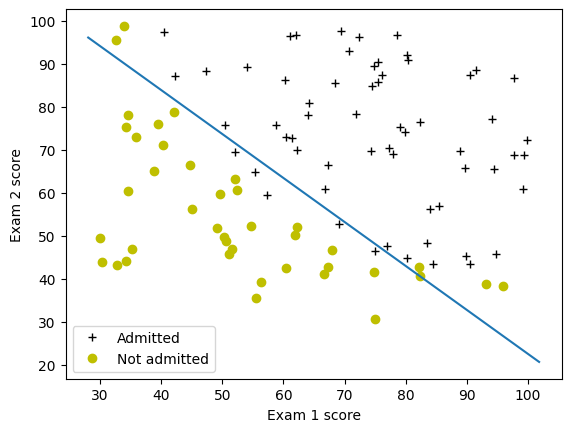

In [11]:
# 此时X是100*3的二维数组，两门考试成绩的ID分别是1和2
pos = data[data[:,2] == 1, 0:2 ]
neg = data[data[:,2] == 0, 0:2 ]
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.plot(pos[:,0], pos[:,1], '+k', label='Admitted') # 绘制正例
plt.plot(neg[:,0], neg[:,1], 'oy', label='Not admitted') # 绘制负例
plt.legend()

pred_x = [np.min(X.T[:,[1]])-2,np.max(X.T[:,[1]])+2]
pred_y = (min_w[0]+np.dot(pred_x,min_w[1]))/(-min_w[2])
plt.plot(pred_x, pred_y)
plt.show()

#### 2.4.2 使用Logistic回归模型进行分类预测
某考生在考试1中得45分，在考试2中得85分。用训练得到的min_w，预测该生被录取的可能

In [12]:
score = np.array([1, 45, 85])
prob = sigmoid(np.dot(score, min_w)) # 此处score和min_w都是一维数组。

print('输出结果应为0.776')
print('预测被录取的可能性为',prob)

输出结果应为0.776
预测被录取的可能性为 0.7761816770363635


#### 2.4.3 在训练数据集上计算准确率

In [15]:
def predict(w, X):
    admitRslt = np.zeros((m,1))
    z = np.dot(w.T, X)

    pos = np.where(z >= 0)
    neg = (z < 0)

    admitRslt = (z >= 0).astype(int).T 
        
    return admitRslt

admit = predict(min_w, X)
print('在训练数据集上的预测准确率为：', np.mean(admit == y)*100, '%')

在训练数据集上的预测准确率为： 89.0 %
